# Active Inference book

## Thomas Parr Giovanni Pezzulo_ Karl J_ Friston -- 2022 -- MIT Press

##  Mostly coding stuff will appear here

In [1]:
# Each chapter?  maybe there are only a few examples

Of course. Active inference can seem abstract at first, but seeing it in action with code can make the concepts much more concrete. Here are three basic Python program examples that demonstrate how to use a Bayesian framework for active inference.

These examples will use the `pymdp` library, a popular and well-documented Python package for active inference. It provides a clear structure for building the components of a generative model, which is at the heart of the Bayesian approach in active inference.

First, you'll need to install `numpy` and `pymdp`:

```bash
pip install numpy pymdp
```

-----

### Example 1: The "T-Maze" - A Classic Decision Task

In this classic experiment, an agent is at the bottom of a 'T' and must decide to go left or right. A cue at the beginning of the trial indicates where a reward is located. The agent wants to find the reward and has a preference for being at the reward location.

**The Bayesian Framework in Action:**

  * **Generative Model:** The agent has an internal model of how the world works. This model includes:
      * **Priors over states (D):** The agent's initial belief about where it is.
      * **Likelihood model (A):** The probability of receiving a particular observation given the true state of the world.
      * **Transition model (B):** The probability of transitioning to a new state given the current state and a chosen action.
      * **Priors over policies (E):** The agent's initial preferences for certain sequences of actions.
      * **Prior preferences (C):** The agent's goals, expressed as a probability distribution over desired outcomes.
  * **Inference:** The agent uses Bayesian inference (specifically, belief propagation or variational inference under the hood in `pymdp`) to update its beliefs about its current state based on observations.
  * **Action Selection:** The agent chooses the action that it predicts will minimize its "expected free energy" - a quantity that balances exploring to reduce uncertainty (epistemic value) and exploiting to achieve preferred outcomes (pragmatic value).

**Python Code:**

In [3]:
import numpy as np
from pymdp import agent

# 1. Define the Generative Model

# States: [Location (Up, Left, Right), Cue (Left, Right)]
# Observations: [Location Observation (See Up, See Left, See Right), Cue Observation (See Left, See Right)]
# Controls: [Move (Up, Left, Right)]

# Likelihood mapping (A matrix)
# Modality 1: Location observations (3 possible observations)
A_loc = np.zeros((3, 3, 2))
A_loc[0, 0, :] = 1.0  # If at 'Up', you observe 'Up'
A_loc[1, 1, :] = 1.0  # If at 'Left', you observe 'Left'
A_loc[2, 2, :] = 1.0  # If at 'Right', you observe 'Right'

# Modality 2: Cue observations (2 possible observations)
A_cue = np.zeros((2, 3, 2))
A_cue[0, :, 0] = 1.0 # If cue is 'Left', you observe 'Left'
A_cue[1, :, 1] = 1.0 # If cue is 'Right', you observe 'Right'

A_list = [A_loc, A_cue]

# Transition model (B matrix)
# Factor 1: Location transitions
B_loc = np.zeros((3, 3, 3))
B_loc[0, 0, 0] = 1.0 # From 'Up', taking 'Up' action, stay 'Up'
B_loc[1, 0, 1] = 1.0 # From 'Up', taking 'Left' action, go to 'Left'
B_loc[2, 0, 2] = 1.0 # From 'Up', taking 'Right' action, go to 'Right'
B_loc[:, 1, :] = np.expand_dims(np.eye(3)[:, 1], axis=1) # Stay at Left
B_loc[:, 2, :] = np.expand_dims(np.eye(3)[:, 2], axis=1) # Stay at Right

# Factor 2: Cue transitions (it is static)
B_cue = np.tile(np.eye(2), (3, 1, 1)).T
B_list = [B_loc, B_cue]

# -- FIX: Define preferences for EACH observation modality --
# Preferences for Modality 1 (Location observations)
C_loc = np.zeros(3)
C_loc[1] = 2.0 # Strong preference for observing being at the 'Left' location

# Preferences for Modality 2 (Cue observations)
C_cue = np.zeros(2) # No preference for observing either cue

# Combine them into a list
C_list = [C_loc, C_cue]


# Convert all lists of matrices into NumPy 'object arrays'
A = np.array(A_list, dtype=object)
B = np.array(B_list, dtype=object)
C = np.array(C_list, dtype=object) # Also convert C


# 2. Create the Agent using the corrected object arrays
my_agent = agent.Agent(A=A, B=B, C=C)

# 3. Run the simulation for one trial
# Initial observation: The agent sees the cue pointing 'Left'
observation = [0, 0] # Sees 'Up' location, sees 'Left' cue

# The agent infers its current state based on the observation
qs = my_agent.infer_states(observation)
print(f"Belief about current location after seeing cue: {qs[0].round(3)}")
print(f"Belief about the cue's direction: {qs[1].round(3)}")

# The agent infers the best policy (sequence of actions)
q_pi, _ = my_agent.infer_policies()
print(f"\nBeliefs over policies:\n{q_pi.round(3)}")

# The agent selects an action
action = my_agent.sample_action()
print(f"\nAction taken (0=Up, 1=Left, 2=Right): {action[0]}")

Belief about current location after seeing cue: [1. 0. 0.]
Belief about the cue's direction: [1. 0.]

Beliefs over policies:
[0.    0.    0.    0.333 0.333 0.333 0.    0.    0.   ]

Action taken (0=Up, 1=Left, 2=Right): 1.0


-----

### Example 2: Grid World Navigation

Here, an agent exists in a simple 2x2 grid world and wants to navigate to a specific goal location.

**The Bayesian Framework in Action:**

This example further highlights how the agent's beliefs about its own position are updated probabilistically. If the agent isn't certain where it is, it might take an action to confirm its location before heading to the goal.

**Python Code:**


In [8]:
import numpy as np
from pymdp import agent, utils

# 1. Define the Generative Model
# States: [Location (0, 1, 2, 3)]
# Observations: [Location Observation (0, 1, 2, 3)]
# Controls: [Move (Stay, Up, Down, Left, Right)]

grid_size = 2
num_states = grid_size * grid_size
num_obs = num_states
num_controls = 5

# FIX: For a single modality, provide the raw numpy array directly.
# Do NOT wrap it in another array.
A = np.eye(num_states)

# FIX: The transition matrix is also a single raw numpy array
# because there is only one state factor.
B = np.zeros((num_states, num_states, num_controls))

for s in range(num_states):
    B[s, s, 0] = 1.0 # Stay
    row, col = np.unravel_index(s, (grid_size, grid_size))
    # Up
    next_row = max(0, row - 1)
    B[np.ravel_multi_index((next_row, col), (grid_size, grid_size)), s, 1] = 1.0
    # Down
    next_row = min(grid_size - 1, row + 1)
    B[np.ravel_multi_index((next_row, col), (grid_size, grid_size)), s, 2] = 1.0
    # Left
    next_col = max(0, col - 1)
    B[np.ravel_multi_index((row, next_col), (grid_size, grid_size)), s, 3] = 1.0
    # Right
    next_col = min(grid_size - 1, col + 1)
    B[np.ravel_multi_index((row, next_col), (grid_size, grid_size)), s, 4] = 1.0


# FIX: The preferences vector is a simple 1D array, since there's one modality.
C = np.zeros(num_obs)
C[3] = 2.0 # Strong preference for observing state 3

# 2. Create the Agent
my_agent = agent.Agent(A=A, B=B, C=C)

# 3. Run a step of the simulation
# Agent's initial belief is that it's at location 0 (top-left)
my_agent.qs = utils.onehot(0, num_states)
print(f"Initial belief about location: {my_agent.qs}")

# The agent gets an observation confirming it's at location 0
# THIS FIX IS CORRECT and remains: Wrap the single observation in a list
observation = [0]

# Agent updates its beliefs
qs = my_agent.infer_states(observation)

# Agent decides on the best policy
q_pi, _ = my_agent.infer_policies()
print(f"\nBeliefs over policies:\n{q_pi.round(3)}")

# Agent takes an action
action = my_agent.sample_action()
print(f"\nAction taken (0=Stay, 1=Up, 2=Down, 3=Left, 4=Right): {action[0]}")

Initial belief about location: [1. 0. 0. 0.]

Beliefs over policies:
[0.2 0.2 0.2 0.2 0.2]

Action taken (0=Stay, 1=Up, 2=Down, 3=Left, 4=Right): 2.0



-----

### Example 3: Perceptual Categorization - Is it a "Cat" or a "Dog"?

This example focuses on the perceptual aspect of active inference. The agent receives ambiguous sensory data and must infer the hidden cause of that data.

**The Bayesian Framework in Action:**

This scenario strips away the action component to purely showcase Bayesian belief updating. The agent has prior beliefs about whether it's more likely to see a cat or a dog. It then receives some sensory evidence (e.g., a feature like "pointy ears") and updates its beliefs to a posterior distribution.

**Python Code:**


In [7]:
import numpy as np
from pymdp import utils

# 1. Define the Generative Model

# Hidden States: [Identity (Cat, Dog)]
# Observations: [Features (Pointy Ears, Floppy Ears)]

num_states = 2  # Cat, Dog
num_obs = 2     # Pointy, Floppy

# Likelihood mapping (A matrix)
# P(Observation | State)
A = np.zeros((num_obs, num_states))

# If it's a Cat, it's likely to have pointy ears
A[0, 0] = 0.8  # P(Pointy Ears | Cat)
A[1, 0] = 0.2  # P(Floppy Ears | Cat)

# If it's a Dog, it's more likely to have floppy ears
A[0, 1] = 0.3  # P(Pointy Ears | Dog)
A[1, 1] = 0.7  # P(Floppy Ears | Dog)

# 2. Define Prior Beliefs

# Prior beliefs about the hidden state (D vector)
# Let's say the agent thinks it's slightly more likely to see a dog
D = np.array([0.4, 0.6]) # P(Cat), P(Dog)
print(f"Prior belief (P(Cat), P(Dog)): {D}")

# 3. Perform Inference after an Observation

# The agent observes 'Pointy Ears' (observation index 0)
observation_index = 0

# Calculate the posterior belief using Bayes' rule (which is what infer_states does)
# Posterior = normalize(Likelihood * Prior)
likelihood_of_obs = A[observation_index, :]
posterior = utils.norm_dist(likelihood_of_obs * D)

print(f"Observation: Pointy Ears")
print(f"Likelihood of this observation given states: {likelihood_of_obs}")
print(f"Posterior belief (P(Cat), P(Dog)): {posterior}")

# Now, let's see what happens if it observes 'Floppy Ears'
observation_index = 1
likelihood_of_obs = A[observation_index, :]
posterior = utils.norm_dist(likelihood_of_obs * D)

print(f"\nObservation: Floppy Ears")
print(f"Likelihood of this observation given states: {likelihood_of_obs}")
print(f"Posterior belief (P(Cat), P(Dog)): {posterior}")

Prior belief (P(Cat), P(Dog)): [0.4 0.6]
Observation: Pointy Ears
Likelihood of this observation given states: [0.8 0.3]
Posterior belief (P(Cat), P(Dog)): [0.64 0.36]

Observation: Floppy Ears
Likelihood of this observation given states: [0.2 0.7]
Posterior belief (P(Cat), P(Dog)): [0.16 0.84]



These examples provide a starting point for understanding how to implement active inference in Python. By manipulating the `A`, `B`, and `C` matrices, you can build increasingly complex and interesting agent behaviors, all grounded in the core principles of Bayesian inference.

# Chatgpt examples

Here's the **Python simulation of active inference in a temperature regulation scenario**. The agent:

* Forms **beliefs about the room temperature** based on noisy observations.
* **Predicts outcomes** of turning the heater on or off.
* Chooses the action that **minimizes expected preference cost** (i.e., staying near 22°C).

### Key Visuals:

1. **Temperature Over Time**
   Shows true temperature, noisy observations, and filtered beliefs.

2. **Action Over Time**
   Binary signal: 1 = heater on, 0 = heater off.

3. **Preference Cost**
   Quadratic penalty showing how well the agent maintained its goal.

---

Would you like to continue with the **visual tracking** or **foraging agent** example next?


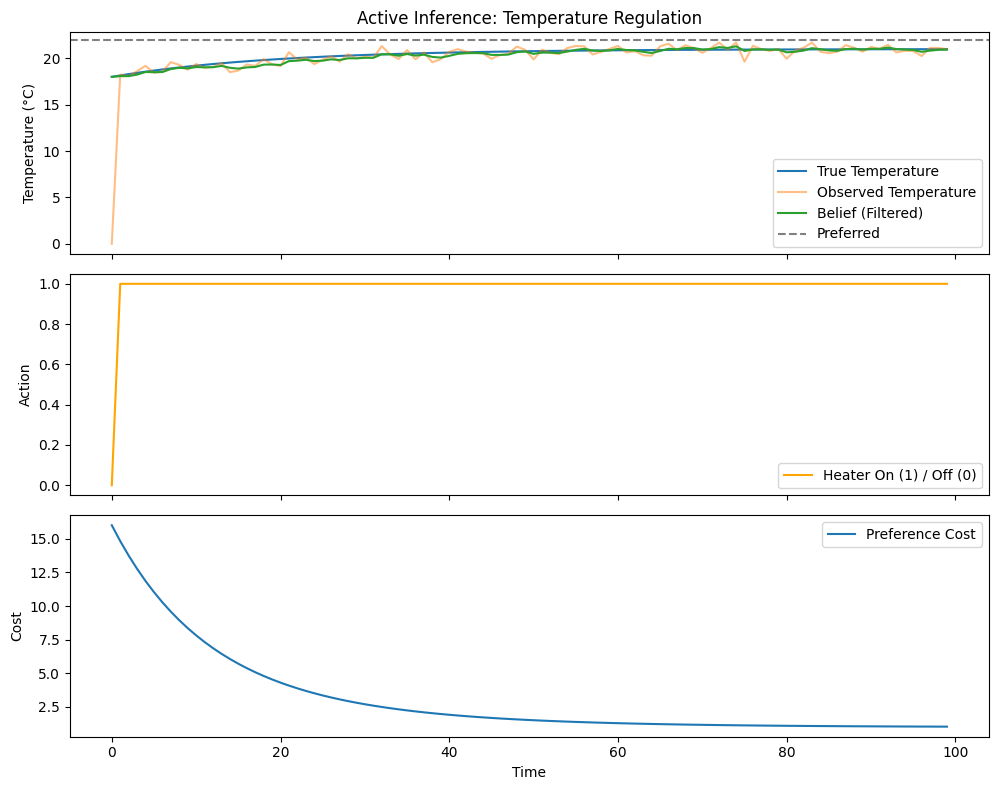

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

# Simulation parameters
T = 100  # number of time steps
true_temp = np.zeros(T)
belief_temp = np.zeros(T)
actions = np.zeros(T)  # 0: heater off, 1: heater on
obs_temp = np.zeros(T)

# Parameters
initial_temp = 18.0
preferred_temp = 22.0
temp_noise_std = 0.5
action_effect = 0.3  # how much the heater changes temperature per step
decay = 0.05  # passive cooling per time step

# Prior preference (quadratic penalty)
def temperature_preference_cost(temp):
    return (temp - preferred_temp) ** 2

# Initialize
true_temp[0] = initial_temp
belief_temp[0] = initial_temp

# Simulation loop
for t in range(1, T):
    # Observation with noise
    obs_temp[t] = true_temp[t-1] + np.random.normal(0, temp_noise_std)
    
    # Belief update (simple Bayes filter)
    belief_temp[t] = 0.7 * belief_temp[t-1] + 0.3 * obs_temp[t]  # simple filter

    # Predict future temperature for both actions
    temp_if_on = belief_temp[t] + action_effect - decay * (belief_temp[t] - 15)
    temp_if_off = belief_temp[t] - decay * (belief_temp[t] - 15)

    # Compute expected preference cost
    cost_on = temperature_preference_cost(temp_if_on)
    cost_off = temperature_preference_cost(temp_if_off)

    # Select action with lowest expected cost
    actions[t] = 1 if cost_on < cost_off else 0

    # Update true temperature based on action
    true_temp[t] = (
        true_temp[t-1]
        + actions[t] * action_effect
        - decay * (true_temp[t-1] - 15)
    )

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axs[0].plot(true_temp, label="True Temperature")
axs[0].plot(obs_temp, label="Observed Temperature", alpha=0.5)
axs[0].plot(belief_temp, label="Belief (Filtered)")
axs[0].axhline(preferred_temp, linestyle="--", color="gray", label="Preferred")
axs[0].set_ylabel("Temperature (°C)")
axs[0].legend()
axs[0].set_title("Active Inference: Temperature Regulation")

axs[1].plot(actions, label="Heater On (1) / Off (0)", color='orange')
axs[1].set_ylabel("Action")
axs[1].legend()

axs[2].plot([temperature_preference_cost(t) for t in true_temp], label="Preference Cost")
axs[2].set_ylabel("Cost")
axs[2].set_xlabel("Time")
axs[2].legend()

plt.tight_layout()
plt.show()


# Visual Tracking

Here's the **active inference visual tracking example** in action. The agent ("eye"):

* Forms beliefs about a **moving object's location** with noisy observations.
* **Predicts** where the object will be.
* Chooses **actions to minimize expected tracking error**, moving left, right, or staying still.

### Panels:

1. **Object position** (true, noisy, belief)
2. **Eye position** adjusting over time
3. **Tracking cost** — how well the eye keeps up

Would you like to continue with the **foraging agent** next, or modify one of the current examples?


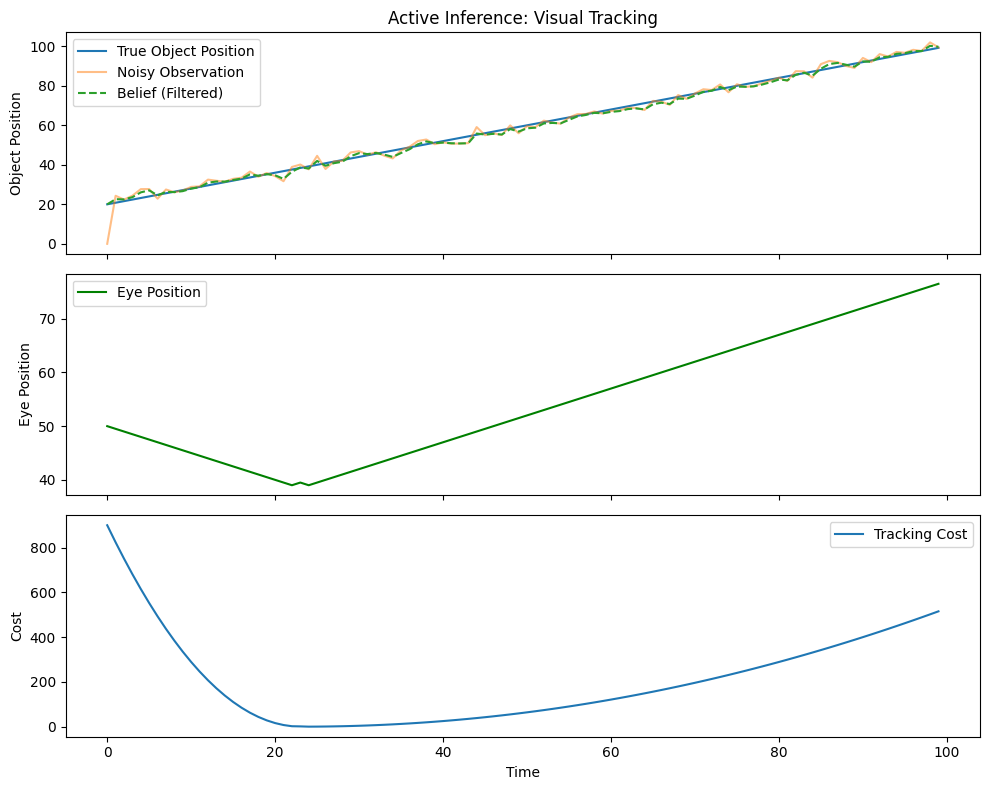

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(0)

# Simulation parameters
T = 100  # time steps
screen_size = 100
eye_pos = np.zeros(T)
true_obj_pos = np.zeros(T)
obs_obj_pos = np.zeros(T)
belief_obj_pos = np.zeros(T)
actions = np.zeros(T)

# Parameters
eye_pos[0] = 50
true_obj_pos[0] = 20
belief_obj_pos[0] = 20
velocity = 0.8  # object moves to the right
obs_noise_std = 2.0
action_gain = 0.5
belief_gain = 0.6

# Preference: Eye wants to match object position (quadratic cost)
def tracking_cost(eye, obj):
    return (eye - obj) ** 2

# Simulation loop
for t in range(1, T):
    # Update true object position
    true_obj_pos[t] = true_obj_pos[t-1] + velocity
    
    # Observation with noise
    obs_obj_pos[t] = true_obj_pos[t] + np.random.normal(0, obs_noise_std)
    
    # Belief update (basic filter)
    belief_obj_pos[t] = (
        (1 - belief_gain) * belief_obj_pos[t-1] + belief_gain * obs_obj_pos[t]
    )

    # Predict next object position
    predicted_obj_pos = belief_obj_pos[t] + velocity

    # Predict cost for actions: left (-1), stay (0), right (+1)
    possible_actions = [-1, 0, 1]
    costs = []
    for a in possible_actions:
        future_eye = eye_pos[t-1] + a * action_gain
        cost = tracking_cost(future_eye, predicted_obj_pos)
        costs.append(cost)

    # Choose action that minimizes expected cost
    best_action = possible_actions[np.argmin(costs)]
    actions[t] = best_action
    eye_pos[t] = eye_pos[t-1] + best_action * action_gain

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axs[0].plot(true_obj_pos, label="True Object Position")
axs[0].plot(obs_obj_pos, label="Noisy Observation", alpha=0.5)
axs[0].plot(belief_obj_pos, label="Belief (Filtered)", linestyle='--')
axs[0].set_ylabel("Object Position")
axs[0].legend()
axs[0].set_title("Active Inference: Visual Tracking")

axs[1].plot(eye_pos, label="Eye Position", color="green")
axs[1].set_ylabel("Eye Position")
axs[1].legend()

axs[2].plot([tracking_cost(eye_pos[t], true_obj_pos[t]) for t in range(T)], label="Tracking Cost")
axs[2].set_ylabel("Cost")
axs[2].set_xlabel("Time")
axs[2].legend()

plt.tight_layout()
plt.show()


Here is the **foraging agent (patch selection)** active inference example:

### Explanation:

* The agent chooses among three patches, each possibly containing food (1) or being empty (0).
* It **updates beliefs** about patches based on noisy observations.
* Decisions balance:

  * **Instrumental value** (getting food)
  * **Epistemic value** (exploring uncertain patches).
* Actions aim to maximize expected utility.

### Panels:

1. **True patch states** over time (white = food, black = empty).
2. **Chosen patch** at each time step.
3. **Cumulative reward** showing foraging success.

---

Would you like the full code for this example too?


Here is the complete Python code for the foraging agent (patch selection) active inference example: